In [4]:
from model.dadmd import DA_DMD
from utils import standardize_minmax
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Train the model

In [5]:
"""
Train the DA-DMD model using synthetic data and save the model.

"""

loss_fn = nn.MSELoss()

def train_model(model, train_loader, num_epochs=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            _, reconstructed = model(X_batch)
            loss = loss_fn(reconstructed, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss / len(train_loader):.6f}")
    return model




hankel_dim = 40

cars = standardize_minmax(np.load('synthetic_data/2_cars_2000.npy'))
raman = standardize_minmax(np.load('synthetic_data/2_raman_2000.npy'))

X_noisy = torch.tensor(cars[:1700, :], dtype=torch.float32).to(device)
X_clean = torch.tensor(raman[:1700, :], dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_noisy, X_clean)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model = DA_DMD(input_dim=1000, num_modes=hankel_dim, Ndelay=hankel_dim).to(device)
trained_model = train_model(model, train_loader, num_epochs=50)



Epoch 1/50, Loss: 0.005022
Epoch 2/50, Loss: 0.001625
Epoch 3/50, Loss: 0.001343
Epoch 4/50, Loss: 0.001271
Epoch 5/50, Loss: 0.001176
Epoch 6/50, Loss: 0.001196
Epoch 7/50, Loss: 0.001074
Epoch 8/50, Loss: 0.001019
Epoch 9/50, Loss: 0.001017
Epoch 10/50, Loss: 0.000954
Epoch 11/50, Loss: 0.000951
Epoch 12/50, Loss: 0.000942
Epoch 13/50, Loss: 0.000942
Epoch 14/50, Loss: 0.000966
Epoch 15/50, Loss: 0.000907
Epoch 16/50, Loss: 0.000872
Epoch 17/50, Loss: 0.000843
Epoch 18/50, Loss: 0.000878
Epoch 19/50, Loss: 0.000819
Epoch 20/50, Loss: 0.000881
Epoch 21/50, Loss: 0.000851
Epoch 22/50, Loss: 0.000845
Epoch 23/50, Loss: 0.000821
Epoch 24/50, Loss: 0.000782
Epoch 25/50, Loss: 0.000789
Epoch 26/50, Loss: 0.000820
Epoch 27/50, Loss: 0.000833
Epoch 28/50, Loss: 0.000780
Epoch 29/50, Loss: 0.000799
Epoch 30/50, Loss: 0.000746
Epoch 31/50, Loss: 0.000748
Epoch 32/50, Loss: 0.000765
Epoch 33/50, Loss: 0.000714
Epoch 34/50, Loss: 0.000732
Epoch 35/50, Loss: 0.000738
Epoch 36/50, Loss: 0.000735
E

# Save model

In [ ]:
## save the model
torch.save(trained_model, 'pretrained_models/pretrained_dadmd_new.pt')

# Test the model

In [8]:
from sklearn.metrics import mean_squared_error
from utils import normalize


def denoise_spectrum(model, raw_spectrum):
    """
    Pass a raw Raman spectrum through the DA-DMD model to denoise it.

    Args:
        model (torch.nn.Module): Trained DA-DMD model
        raw_spectrum (np.ndarray): 1D input spectrum of shape (spectrum_length,)

    Returns:
        np.ndarray: Denoised output spectrum of shape (spectrum_length,)
    """
    model.eval()
    spectrum_tensor = torch.tensor(raw_spectrum, dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        _, denoised_spectrum = model(spectrum_tensor)

    return denoised_spectrum.cpu().numpy().squeeze()



# Load and preprocess data
cars = standardize_minmax(np.load('synthetic_data/2_cars_2000.npy'))
raman = standardize_minmax(np.load('synthetic_data/2_raman_2000.npy'))

X_noisy = cars[1700:, :]   # test input
X_clean = raman[1700:, :]  # ground truth

# Load model and pretrained weights
trained_model = torch.load('pretrained_models/pretrained_dadmd.pt')

# Run denoising on all test samples
test_losses = []
for i in range(len(X_noisy)):
    noisy_input = normalize(X_noisy[i]).copy()
    clean_target = normalize(X_clean[i]).copy()

    output = denoise_spectrum(trained_model, noisy_input)

    loss = mean_squared_error(output, clean_target)
    test_losses.append(loss)

    # print(f"Sample {i+1}/{len(X_noisy)} - MSE Loss: {loss:.6f}")

print(f"Average Test Loss: {np.mean(test_losses):.6f}")

/home/valapil/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number inf. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/valapil/.local/lib/python3.10/site-packages/pydmd/dmdoperator.py:176: RuntimeWarning: divide by zero encountered in reciprocal
  return np.linalg.multi_dot([U.T.conj(), Y, V]) * np.reciprocal(s)
/home/valapil/.local/lib/python3.10/site-packages/pydmd/dmdoperator.py:176: RuntimeWarning: invalid value encountered in multiply
  return np.linalg.multi_dot([U.T.conj(), Y, V]) * np.reciprocal(s)
/home/valapil/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number inf. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/valapil/.local/lib/python3.10/site-packages/pydmd/dmdoperator.py:176: RuntimeWarning: divide by zero encountered in reciprocal
  return np.lina

Average Test Loss: 0.000598


# Plot a DA-DMD reconstruction

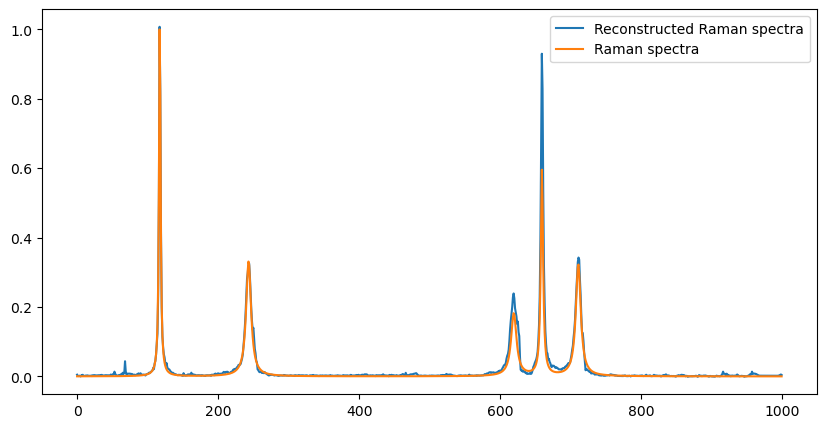

In [9]:
import matplotlib.pyplot as plt

noisy = cars[1997, :] 
clean = raman[1997, :] 
result = denoise_spectrum(trained_model, noisy)

plt.figure(figsize=(10,5))
plt.plot(result, label='Reconstructed Raman spectra')
plt.plot(clean, label='Raman spectra')
plt.legend()
plt.show()